In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Input
from tensorflow.keras.optimizers import Adam

2025-05-09 08:49:14.417210: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-09 08:49:14.422004: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-09 08:49:14.436227: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746780554.460328   22191 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746780554.467411   22191 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746780554.486391   22191 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [9]:
# Load dataset
df = pd.read_csv("dataset.csv")

# Convert and sort dates
df['Date'] = pd.to_datetime(df['Date'], utc=True)
df.sort_values('Date', inplace=True)

# Normalize 'Close' prices
scaler = MinMaxScaler()
df['Scaled_Close'] = scaler.fit_transform(df[['Close']])

In [3]:
def create_sequences(data, look_back=30):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back])
    return np.array(X), np.array(y)

look_back = 30
X, y = create_sequences(df['Scaled_Close'].values, look_back)
X = X.reshape((X.shape[0], X.shape[1], 1))  # For GRU input

In [ ]:
model = Sequential([
    Input(shape=(look_back, 1)),
    GRU(50, return_sequences=False),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

2025-05-09 08:49:16.237683: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
# Train the model
history = model.fit(X, y, epochs=20, batch_size=16, verbose=1)

Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0127
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.7605e-04
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.3248e-04
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.3973e-04
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.4412e-04
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.2564e-04
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.5703e-04
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.0179e-04
Epoch 9/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9361e-04
Epoch 10/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.0204e-04
Epoch 11/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.9984e-04
Epoch 12/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.9033e-04
Epoch 13/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.8287e-04
Epoch 14/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.8003e-04
Epoch 15/20
77/77 ━━━━━━━━━━━━━━━

In [6]:
# Predict
y_pred_scaled = model.predict(X)

# Inverse transform predictions and actual values
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = scaler.inverse_transform(y.reshape(-1, 1)).flatten()

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [7]:
# Metrics
rmse_score = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("Root Mean Squared Error (RMSE):", rmse_score)
print("R² Score:", r2)

Root Mean Squared Error (RMSE): 22.32624684721281
R² Score: 0.9961918235202044


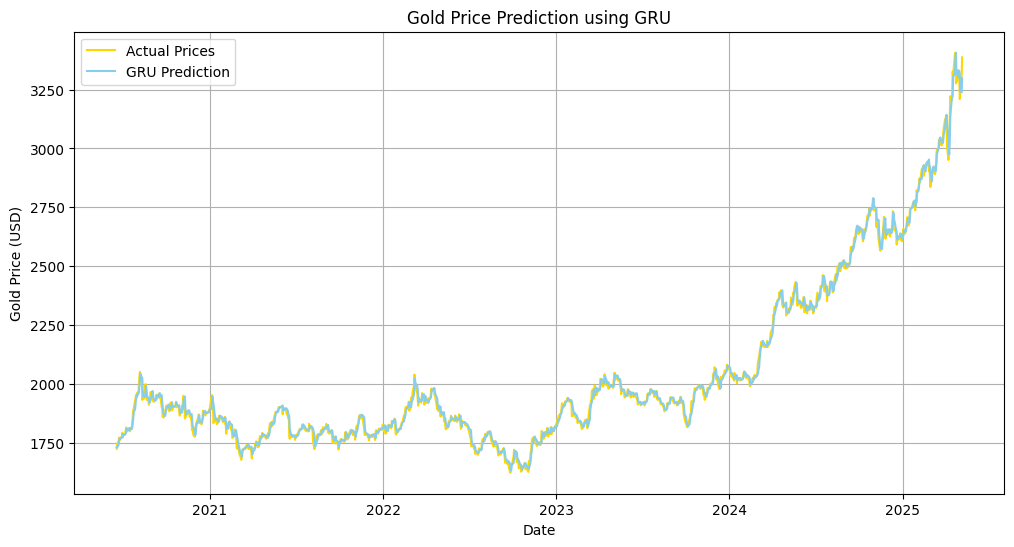

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'][look_back:], y_true, label='Actual Prices', color='gold')
plt.plot(df['Date'][look_back:], y_pred, label='GRU Prediction', color='skyblue')
plt.xlabel('Date')
plt.ylabel('Gold Price (USD)')
plt.title('Gold Price Prediction using GRU')
plt.legend()
plt.grid(True)
plt.show()